In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from scipy.signal import savgol_filter

In [2]:
data = pd.read_csv('timeseries-country-confirmed.csv',usecols=['Date','Cases','Country'])
C1=data[data['Country']=='United States']
C1=C1[C1['Date']>'2022/5/17']
date = np.array(C1['Date'].astype(str))
xs = [datetime.strptime(d, '%Y/%m/%d').date() for d in date]
C=C1['Cases'].values

In [3]:
def moving_average(interval, windowsize):
    window = np.ones(int(windowsize)) / float(windowsize)
    re = np.convolve(interval, window, 'same')
    return re

In [4]:
def RLS(x,y):
    l=0.65 #遗忘因子 y=x*w
    R={};z={};P={};w={};k={}
    R[0]=x[0]*x[0]
    z[0]=x[0]*y[0]
    P[0]=1/R[0]
    w[0]=(1/R[0])*z[0]
    for i in range(1,len(x)):
        k[i]=(P[i-1]*x[i])/(l+x[i]*P[i-1]*x[i])
        P[i]=(1/l)*P[i-1]-(1/l)*k[i]*x[i]*P[i-1]
        w[i]=w[i-1]-k[i]*(x[i]*w[i-1]-y[i])
    return w

In [5]:
C =moving_average(C,7)

In [6]:
q=1/8.7
E=np.zeros(len(C))
for i in range(len(C)):
    E[i]=C[i]/q 

In [7]:
Su={};I={};SA={};X={};Y={};Bu={};R={};T={};Rt={};
Ep={};
theta=0.76
SA[0]=332854719*(1-theta)
Su[0]=332854719*theta
I[0]=35
Ep[0]=35*8
R[0]=0
T[0]=0
d=0.0081
N=332854719
q=1/8.7 
g=1/21 
for t in range(len(C)-1):
        I[t + 1] = I[t] + 0.983* q * E[t] - g * I[t]
        R[t + 1] = R[t] + g *(1-0.983)* E[t] + g * I[t] 
        Y[t] = E[t + 1] - E[t] + I[t+1]-I[t] +R[t+1]-R[t]
        X[t] = (0.15 * SA[t] * I[t] + Su[t] * I[t]) / N
        Bu = RLS(X, Y)
        SA[t + 1] = SA[t] - Bu[t] * 0.15 * SA[t] * I[t] / N
        Su[t + 1] = Su[t] - Bu[t] * Su[t] * I[t] / N
        Rt[t] = 0.983 / g  * (Bu[t] * 0.15 * SA[t] + Bu[t] * Su[t]) / N
        Ep[t + 1] = Ep[t] + Bu[t] * 0.15 * SA[t] * I[t] / N + Bu[t] * Su[t] * I[t] / N - q * Ep[t]
        T[t + 1] = T[t] + 0.983* q * Ep[t]


In [8]:
import gurobipy as gp
from gurobipy import GRB

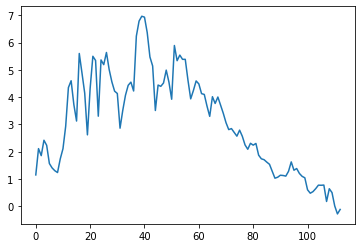

In [9]:
plt.plot(Rt.values())

In [10]:
y = []
T = len(Rt)
for i in range(len(Rt)):
    y.append(Rt[i])#Tx1
y = np.array(y)

In [11]:
D=np.zeros((T-2,T))#(T-2)xT

In [12]:
for i in range(T-2):
    D[i][i] = 1
    D[i][i+1] = -2
    D[i][i+2] = 1

In [13]:
M = -100
for i in range(1,T-1):
    temp = y[i-1]-2*y[i]+y[i+1]
    if np.abs(temp)>M:
        M=np.abs(temp)
print(M)

4.104383475979417


In [14]:
model= gp.Model('model')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-17


In [15]:
lambda_=1

In [16]:
y_min = y.min()
y_max = y.max()

In [17]:
f = model.addMVar(T, lb=y_min, ub=y_max, vtype=GRB.CONTINUOUS, name='f')

In [18]:
z = model.addMVar(T-2, vtype=GRB.BINARY, name='z')

In [19]:
model.setObjective(gp.quicksum((y[i]-f[i])**2 for i in range(T))+ lambda_*gp.quicksum((f[i-1]-2*f[i]+f[i+1])**2 for i in range(1,T-1))
                   , GRB.MINIMIZE)

In [20]:
model.addConstr(z.sum()<=4)

<(1,) matrix constraint>

In [21]:
model.addConstr(D@f<=M*z)
model.addConstr(D@f>=-M*z)

<(111,) matrix constraint *awaiting model update*>

In [22]:
model.update()
model.write('model.lp')

In [23]:
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 223 rows, 224 columns and 999 nonzeros
Model fingerprint: 0x76d87579
Model has 336 quadratic objective terms
Variable types: 113 continuous, 111 integer (111 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [3e-02, 1e+01]
  QObjective range [4e+00, 2e+01]
  Bounds range     [3e-01, 7e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 1648.8859221
Presolve time: 0.00s
Presolved: 223 rows, 224 columns, 999 nonzeros
Presolved model has 336 quadratic objective terms
Variable types: 113 continuous, 111 integer (111 binary)

Root relaxation: objective 1.648459e+01, 692 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   16.48

In [24]:
res=[]

In [25]:
for v in model.getVars():
    res.append(v.x)
res = np.array(res)

In [26]:
Res = {};
for i in range(len(res)):
    Res[i] = res[i]
Res.values()

dict_values([1.2348633145426602, 1.3943870799359233, 1.5539108453291863, 1.7134346107224494, 1.8729583761157125, 2.0324821415089755, 2.1920059069022386, 2.351529672295504, 2.511053437688769, 2.6705772030820345, 2.8301009684753, 2.989624733868565, 3.1491484992618304, 3.3086722646550957, 3.468196030048361, 3.6277197954416263, 3.7872435608348916, 3.946767326228157, 4.106291091621422, 4.265814857014687, 4.425338622407953, 4.584862387801218, 4.744386153194482, 4.903909918587747, 5.063433683981011, 5.222957449374276, 5.382481214767541, 5.032053535510487, 4.681625856253433, 4.331198176996379, 3.980770497739325, 3.6303428184822693, 3.279915139225217, 3.7855345390709108, 4.2911539389166045, 4.796773338762298, 5.302392738607992, 5.808012138453686, 6.313631538299379, 6.819250938145076, 6.497094724166291, 6.174938510187506, 5.85278229620872, 5.530626082229936, 5.208469868251155, 5.12943761258699, 5.050405356922826, 4.971373101258662, 4.892340845594497, 4.813308589930331, 4.734276334266167, 4.65524

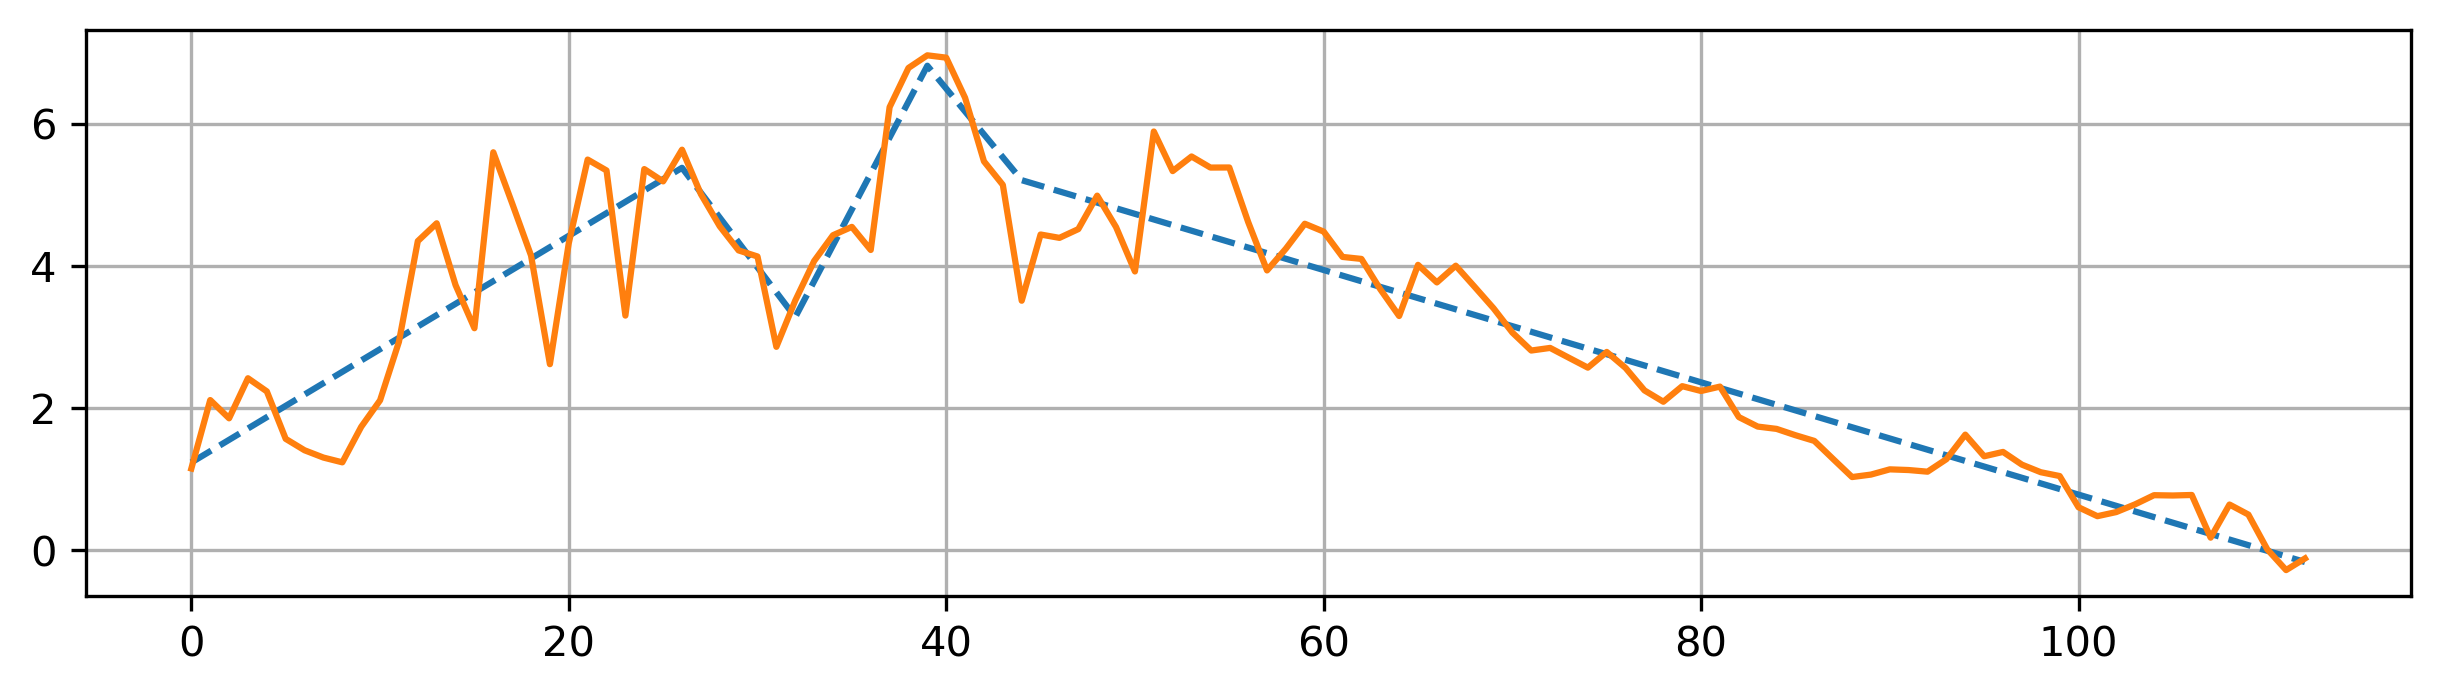

In [27]:
plt.figure(figsize=(10, 2.5), dpi=300)
plt.plot(res[:len(Rt)],'--')
plt.plot(Rt.values())
plt.grid()
#plt.xlim(0,99)
#plt.ylim(-1.1,1.1)
#plt.vlines([13,37,62,86],-1.1,1.1,linestyles='dashed', colors='black')

In [28]:
for v in model.getVars():
    print('%s %g' % (v.Varname,v.x))

f[0] 1.23486
f[1] 1.39439
f[2] 1.55391
f[3] 1.71343
f[4] 1.87296
f[5] 2.03248
f[6] 2.19201
f[7] 2.35153
f[8] 2.51105
f[9] 2.67058
f[10] 2.8301
f[11] 2.98962
f[12] 3.14915
f[13] 3.30867
f[14] 3.4682
f[15] 3.62772
f[16] 3.78724
f[17] 3.94677
f[18] 4.10629
f[19] 4.26581
f[20] 4.42534
f[21] 4.58486
f[22] 4.74439
f[23] 4.90391
f[24] 5.06343
f[25] 5.22296
f[26] 5.38248
f[27] 5.03205
f[28] 4.68163
f[29] 4.3312
f[30] 3.98077
f[31] 3.63034
f[32] 3.27992
f[33] 3.78553
f[34] 4.29115
f[35] 4.79677
f[36] 5.30239
f[37] 5.80801
f[38] 6.31363
f[39] 6.81925
f[40] 6.49709
f[41] 6.17494
f[42] 5.85278
f[43] 5.53063
f[44] 5.20847
f[45] 5.12944
f[46] 5.05041
f[47] 4.97137
f[48] 4.89234
f[49] 4.81331
f[50] 4.73428
f[51] 4.65524
f[52] 4.57621
f[53] 4.49718
f[54] 4.41815
f[55] 4.33912
f[56] 4.26008
f[57] 4.18105
f[58] 4.10202
f[59] 4.02299
f[60] 3.94395
f[61] 3.86492
f[62] 3.78589
f[63] 3.70686
f[64] 3.62782
f[65] 3.54879
f[66] 3.46976
f[67] 3.39073
f[68] 3.3117
f[69] 3.23266
f[70] 3.15363
f[71] 3.0746
f[72] 2